In [1]:
**Automatic Number Plate Recognition
**dataset: https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [2]:
data_annotations = os.path.join('annotations')
data_images = os.path.join('images')

In [3]:
IMAGE_SIZE = 224

In [5]:
img_dir = 'images'
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

In [6]:
from lxml import etree
def resize_annotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [8]:
path = 'annotations'
text_files = ['annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resize_annotation(i))

In [9]:
resize_annotation("annotations/Cars147.xml")

[188, 141, 101, 104]

In [10]:
np.array(X).shape

(433, 224, 224, 3)

In [11]:
np.array(y).shape

(433, 4)

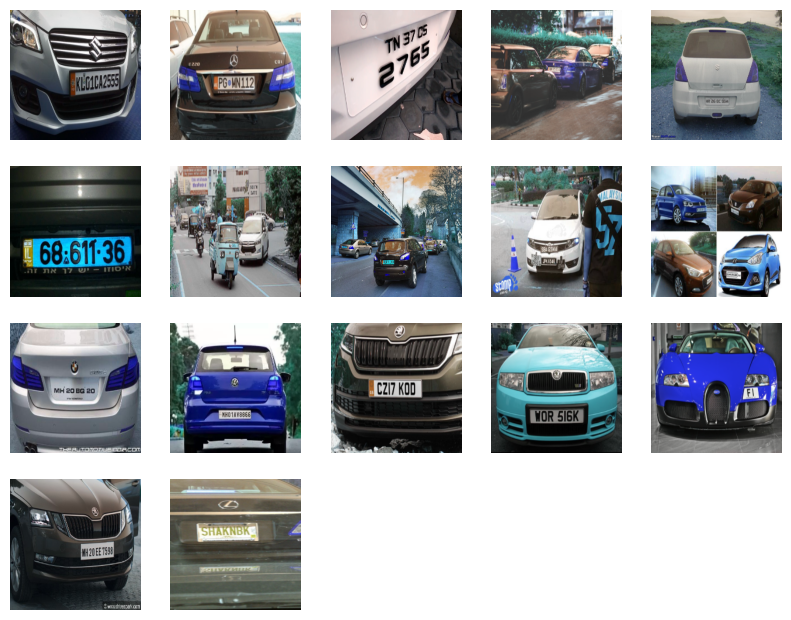

In [12]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

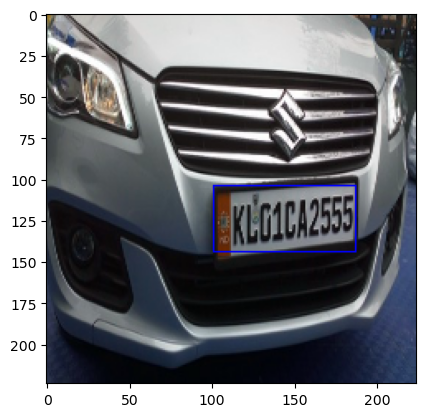

In [13]:
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [14]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [15]:
#Renormalisation
X = X / 255
y = y / 255

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

**Convolution Neural network

In [19]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.losses import Huber
from keras.optimizers import Adam
from keras.applications import VGG16

# Завантажуємо базову модель
base_model = VGG16(
    weights="imagenet", 
    include_top=False, 
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Заморожуємо всі шари VGG16
for layer in base_model.layers:
    layer.trainable = False

# Створюємо нову голову моделі
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),                     # краще за Flatten для фіч
    Dense(512, activation='relu'),
    BatchNormalization(),                         # стабілізує навчання
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(4, activation='sigmoid')                 # (xmin, ymin, xmax, ymax), нормалізовані між 0 і 1
])

# Компіляція моделі
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=Huber(delta=1.0),   # Smooth L1 Loss
    metrics=['mae']
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [20]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 [==============================] - 32s 3s/step - loss: 0.0507 - mae: 0.2606 - val_loss: 0.0233 - val_mae: 0.1720
Epoch 2/50
10/10 [==============================] - 34s 3s/step - loss: 0.0429 - mae: 0.2359 - val_loss: 0.0224 - val_mae: 0.1688
Epoch 3/50
10/10 [==============================] - 40s 4s/step - loss: 0.0363 - mae: 0.2157 - val_loss: 0.0210 - val_mae: 0.1635
Epoch 4/50
10/10 [==============================] - 44s 4s/step - loss: 0.0340 - mae: 0.2079 - val_loss: 0.0193 - val_mae: 0.1572
Epoch 5/50
10/10 [==============================] - 41s 4s/step - loss: 0.0313 - mae: 0.2004 - val_loss: 0.0176 - val_mae: 0.1501
Epoch 6/50
10/10 [==============================] - 41s 4s/step - loss: 0.0276 - mae: 0.1911 - val_loss: 0.0163 - val_mae: 0.1441
Epoch 7/50
10/10 [==============================] - 41s 4s/step - loss: 0.0255 - mae: 0.1804 - val_loss: 0.0154 - val_mae: 0.1392
Epoch 8/50
10/10 [==============================] - 41s 4s/step - loss: 0.0244 - mae: 0.17

In [22]:
# Evaluation of the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Test Loss: 0.0109
Test MAE: 0.1111


In [30]:
def plot_scores(train):
    mae = train.history['mae']
    val_mae = train.history['val_mae']
    loss = train.history['loss']
    val_loss = train.history['val_loss']

    epochs = range(1, len(mae) + 1)

    # Графік MAE
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, mae, 'bo-', label='MAE training')
    plt.plot(epochs, val_mae, 'ro-', label='MAE validation')
    plt.title('MAE by epochs')
    plt.xlabel('epoch')
    plt.ylabel('MAE')
    plt.legend()

    # Графік Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Loss training')
    plt.plot(epochs, val_loss, 'ro-', label='Loss validation')
    plt.title('Loss by epochsи')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

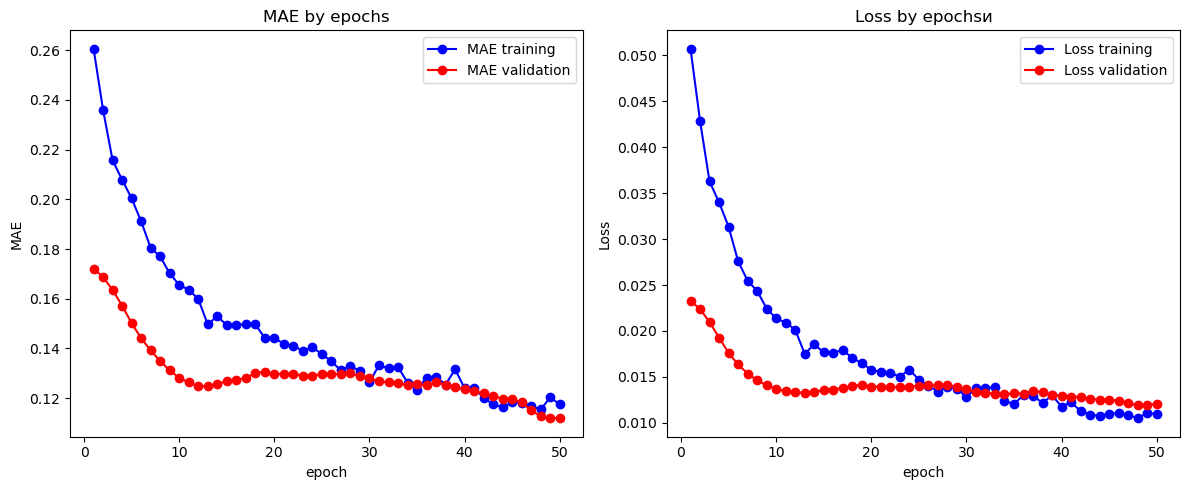

In [31]:
plot_scores(train)

In [25]:
plot_scores()

3/3 [==============================] - 8s 2s/step
